In [102]:
import struct
import mmap
import numpy
import time
from PIL import Image
import matplotlib.pyplot as plt

In [103]:
class Readbmp(object): # leer el bmp
    def __init__(self, path):
        self.path = path
        self.fraction = 20
        self.matrix = []

        self.read()
        self.generateMatrix()
        self.generateMatrixZeros()
        self.discretization()



    def color(self, r, g, b): # definir los colores
      return bytes([b, g, r])

    def read(self): # recorrer el bmp
        self.aux = []
        self.processed = []
        self.buffer = []

        img = open(self.path, "rb")
        m = mmap.mmap(img.fileno(), 0, access=mmap.ACCESS_READ)
        ba = bytearray(m)
        header_size = struct.unpack("=l", ba[10:14])[0]
        self.width = struct.unpack("=l", ba[18:22])[0]
        self.height = struct.unpack("=l", ba[18:22])[0]
        all_bytes = ba[header_size::]
        self.pixels = numpy.frombuffer(all_bytes, dtype='uint8')
        img.close()

        for i in range(len(self.pixels)):
          self.aux.append(self.pixels[i])
          if (len(self.aux) == 3):
            color = [self.aux[0], self.aux[1], self.aux[2]]
            color = numpy.array(color,numpy.uint8)
            color = self.color(self.aux[0], self.aux[1], self.aux[2])
            self.processed.append(color)
            self.aux = []
            if (len(self.processed) == self.width):
              self.buffer.append(self.processed)
              self.processed = []

        return self.buffer

    def generateMatrix(self): # genera la matriz para el mapa
      self.matrix =  [[self.color(0, 0, 0) for x in range(self.fraction)] for y in range(self.fraction)]

    def generateMatrixZeros(self): # aplicamos zeros a la matriz para la discretizacion
      self.maze =  [[0 for x in range(self.fraction)] for y in range(self.fraction)]

    def discretization(self):
      self.startCoor = []
      self.endingCoor = []

      color = self.color(1, 1, 1)
      bff = self.buffer
      init_index_x, init_index_y = 0, 0
      end_index_x, end_index_y = 29, 29

      path_Counter, goal_Counter = 0, 0
      indexErr, indexFlag = 0, 0

      for big_X in range(self.fraction):
        for big_Y in range(self.fraction):
          for lil_x in range(init_index_x, end_index_x):
            for lil_y in range(init_index_y, end_index_y):

              if bff[lil_x][lil_y] == self.color(255, 255, 255):
                path_Counter += 1
              elif bff[lil_x][lil_y] == self.color(0, 0, 0):
                color = ''
              elif bff[lil_x][lil_y] == self.color(254, 0, 0):
                color = bff[lil_x][lil_y]
              else:
                goal_Counter += 1

          proportion = path_Counter/(29**2)
          yIndex = (((big_Y-indexErr)%20)+indexFlag)%20

          if proportion >= 0.5:
            self.matrix[big_X][yIndex] = self.color(255, 255, 255)
            self.maze[big_X][yIndex] = 0

          elif goal_Counter > 50 and not color:
            self.matrix[big_X][yIndex] = self.color(5, 252, 6)
            self.endingCoor.append([big_X, yIndex])

          elif color:
            self.matrix[big_X][yIndex] = color
            self.startCoor = [big_X, yIndex]

          else:
            self.matrix[big_X][yIndex] = self.color(0, 0, 0)
            self.maze[big_X][yIndex] = 1

          init_index_y += 29
          end_index_y += 29
          path_Counter = 0
          goal_Counter = 0

        indexErr += 1
        if indexErr >= 4:
          indexFlag = 2
        if indexErr >= 8:
          indexFlag = 3
        if indexErr >= 16:
          indexFlag = 5

        init_index_y = 0
        end_index_y = 29
        init_index_x += 29
        end_index_x += 29

    def make_step(self, k, m): #
      a = self.maze
      for i in range(len(m)):
        for j in range(len(m[i])):
          if m[i][j] == k:
            if i>0 and m[i-1][j] == 0 and a[i-1][j] == 0:
              m[i-1][j] = k + 1
            if j>0 and m[i][j-1] == 0 and a[i][j-1] == 0:
              m[i][j-1] = k + 1
            if i<len(m)-1 and m[i+1][j] == 0 and a[i+1][j] == 0:
              m[i+1][j] = k + 1
            if j<len(m[i])-1 and m[i][j+1] == 0 and a[i][j+1] == 0:
              m[i][j+1] = k + 1


    def bfs(self): # breadth first search
      maze = self.maze
      start, ending = self.startCoor, self.endingCoor
      self.pathCost = []
      self.paths = []

      for e in ending:

        m = []
        for i in range(len(maze)):
            m.append([])
            for j in range(len(maze[i])):
                m[-1].append(0)
        i,j = start
        m[i][j] = 1

        k = 0
        max_iter = 10000;
        while m[e[0]][e[1]] == 0 and max_iter > 0:
          k += 1
          self.make_step(k, m)
          max_iter-=1

        i, j = e
        k = m[i][j]
        the_path = [(i,j)]

        while k > 1:
          if i > 0 and m[i - 1][j] == k-1:
            i, j = i-1, j
            the_path.append((i, j))
            k-=1

          elif j > 0 and m[i][j - 1] == k-1:
            i, j = i, j-1
            the_path.append((i, j))
            k-=1

          elif i < len(m) - 1 and m[i + 1][j] == k-1:
            i, j = i+1, j
            the_path.append((i, j))
            k-=1

          elif j < len(m[i]) - 1 and m[i][j + 1] == k-1:
            i, j = i, j+1
            the_path.append((i, j))
            k -= 1


        self.pathCost.append(len(the_path))
        self.paths.append(the_path)

      min_val = min(self.pathCost)
      min_index = self.pathCost.index(min_val)

      return self.paths[min_index]

    def resultPath(self): # colorear el path
      min_path = self.bfs()
      for coord in min_path:
        self.matrix[coord[0]][coord[1]] = self.color(255, 0, 255)
      self.matrix[min_path[0][0]][min_path[0][1]] = self.color(5, 252, 6)
      self.matrix[coord[0]][coord[1]] = self.color = self.color(254, 0, 0)


class Writebmp(object): # output bmp

  def char(self, c): # string a char ascii de 1 byte
    return struct.pack('=c', c.encode('ascii'))

  def word(self, w): # string a word de 2 bytes
    return struct.pack('=h', w)

  def dword(self, d): # string a double word de 4 bytes
    return struct.pack('=l', d)

  def toBytes(self, r,g,b): # codificar color
      r = int(max(min(r, 255), 0))
      g = int(max(min(g, 255), 0))
      b = int(max(min(b, 255), 0))
      return bytes([b, g, r])

  def writebmp(self, filename, width, height, pixels): # escribir el bmp
    f = open(filename, 'bw')

    f.write(self.char('B'))
    f.write(self.char('M'))
    f.write(self.dword(14 + 40 + width * height * 3))
    f.write(self.dword(0))
    f.write(self.dword(14 + 40))
    f.write(self.dword(40))
    f.write(self.dword(width))
    f.write(self.dword(height))
    f.write(self.word(1))
    f.write(self.word(24))
    f.write(self.dword(0))
    f.write(self.dword(width * height * 3))
    f.write(self.dword(0))
    f.write(self.dword(0))
    f.write(self.dword(0))
    f.write(self.dword(0))

    for x in range(height):
      for y in range(width):
        f.write(pixels[x][y])

    f.close()

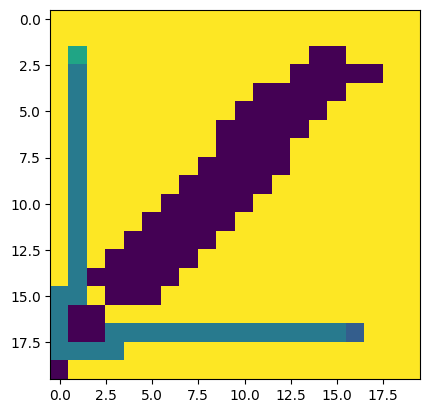

In [104]:
reader = Readbmp("/content/Test0.bmp")
writer = Writebmp()
reader.resultPath()
writer.writebmp("result0.bmp", reader.fraction, reader.fraction, reader.matrix)

img= Image.open('result0.bmp')
result0 = img.convert(mode="L")
plt.imshow(result0)
plt.show()

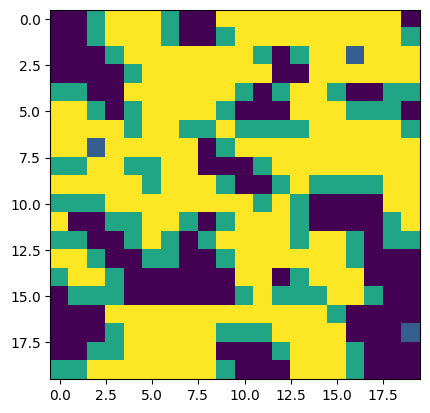

In [105]:
reader = Readbmp("/content/Test1.bmp")
writer = Writebmp()
reader.resultPath()
writer.writebmp("result1.bmp", reader.fraction, reader.fraction, reader.matrix)

img= Image.open('result1.bmp')
result1 = img.convert(mode="L")
plt.imshow(result1)
plt.show()

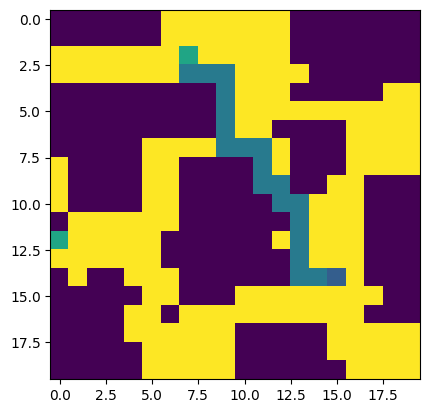

In [108]:
reader = Readbmp("/content/Test2.bmp")
writer = Writebmp()
reader.resultPath()
writer.writebmp("result2.bmp", reader.fraction, reader.fraction, reader.matrix)

img= Image.open('result2.bmp')
result2 = img.convert(mode="L")
plt.imshow(result2)
plt.show()

Referencias

* https://www.appsloveworld.com/coding/python3x/6/reading-bmp-files-in-python
*
*  https://favtutor.com/blogs/breadth-first-search-python